In [ ]:
!pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 4.0 MB/s 


In [ ]:
import tempfile
import os
import sys

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
import math

np.set_printoptions(threshold=sys.maxsize)

In [ ]:
# Load MNIST dataset
red_data = 5
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
btest_images = test_images
# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.expand_dims(train_images, axis=-1)
train_images = tf.image.resize(train_images, [red_data,red_data])
train_images = np.squeeze(train_images, axis=(3,))
# print(train_images.shape)
test_images = np.expand_dims(test_images, axis=-1)
test_images = tf.image.resize(test_images, [red_data,red_data])
test_images = np.squeeze(test_images, axis=(3,))

print(train_images.shape, test_images.shape)
# Define the model architecture.


(60000, 5, 5) (10000, 5, 5)


In [ ]:
model = keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(red_data, red_data)),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.1,
)

Epoch 1/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.6009 - accuracy: 0.4683 - val_loss: 1.1651 - val_accuracy: 0.6158
Epoch 2/10
1688/1688 [==============================] - 4s 2ms/step - loss: 1.1642 - accuracy: 0.6092 - val_loss: 1.0704 - val_accuracy: 0.6392
Epoch 3/10
1688/1688 [==============================] - 8s 4ms/step - loss: 1.1227 - accuracy: 0.6215 - val_loss: 1.0448 - val_accuracy: 0.6443
Epoch 4/10
1688/1688 [==============================] - 9s 5ms/step - loss: 1.1057 - accuracy: 0.6267 - val_loss: 1.0295 - val_accuracy: 0.6490
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 1.0948 - accuracy: 0.6296 - val_loss: 1.0215 - val_accuracy: 0.6510
Epoch 6/10
1688/1688 [==============================] - 4s 2ms/step - loss: 1.0868 - accuracy: 0.6328 - val_loss: 1.0173 - val_accuracy: 0.6507
Epoch 7/10
1688/1688 [==============================] - 4s 2ms/step - loss: 1.0806 - accuracy: 0.6342 - val_loss: 1.0092 - val_accuracy:

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.6527000069618225
Saved baseline model to: /tmp/tmp3wztjumi.h5


In [ ]:

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.91,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)
# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
  1/422 [..............................] - ETA: 14:30 - loss: 1.0758 - accuracy: 0.6641

422/422 [==============================] - 3s 3ms/step - loss: 1.8391 - accuracy: 0.3201 - val_loss: 2.0921 - val_accuracy: 0.1365
Epoch 2/2
422/422 [==============================] - 1s 3ms/step - loss: 2.1432 - accuracy: 0.2034 - val_loss: 2.1335 - val_accuracy: 0.2360


In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:',baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.6527000069618225
Pruned test accuracy: 0.23999999463558197


In [ ]:
def make_newArray(arr) :
  m, n = arr.shape
  x = 0
  for i in range(m) :
    for j in range(n) :
      arr[i][j] = int(math.floor(arr[i][j]*100))
      x = max(x, abs(arr[i][j]))
  print(x)
  return arr

def make_int_bias(arr) :
  m = arr.shape[0]
  li = []
  for i in range(m) :
    li.append(int(math.floor(arr[i]*10000)))
  return li


**Multiply bias by 10000 and weights by 100**

In [ ]:
def convert_matrix_to_csr(sparse_matrix) :
  m, n = sparse_matrix.shape
  nnz = 0
  values = []
  column = []
  row_ptr = []
  for r in range(m) :
    row_ptr.append(nnz)
    for c in range(n) :
      if(sparse_matrix[r][c] != 0) :
        nnz = nnz + 1
        values.append(int(sparse_matrix[r][c]))
        column.append(c)
  row_ptr.append(nnz)
  return nnz, values, column, row_ptr


In [ ]:
weights = model_for_pruning.get_weights()
first_layer_weights = weights[1]
first_layer_biases = weights[2]
first_layer_weights_mask = weights[3]
first_layer_weights = first_layer_weights * first_layer_weights_mask
second_layer_weights = weights[6]
second_layer_biases = weights[7]
second_layer_weights_mask = weights[8]
second_layer_weights = second_layer_weights * second_layer_weights_mask
first_layer_weights = make_newArray(first_layer_weights.T)
second_layer_weights = make_newArray(second_layer_weights.T)

# first_layer_weights_transposed = first_layer_weights.T
# second_layer_weights_transposed = second_layer_weights.T


first_layer_biases = list(make_int_bias(first_layer_biases))
second_layer_biases = list(make_int_bias(second_layer_biases))

print(first_layer_weights.shape)
# print(first_layer_biases, second_layer_biases)

575.0
347.0
(10, 25)


In [ ]:
nnzf, valuesf, columnf, row_ptrf = convert_matrix_to_csr(first_layer_weights)
nnzs, valuess, columns, row_ptrs = convert_matrix_to_csr(second_layer_weights)

print(nnzf)
print(valuesf)
print(columnf)
print(row_ptrf)

print(first_layer_biases)
print(nnzs)
print(valuess)
print(columns)
print(row_ptrs)

print(second_layer_biases)

23
[-279, -575, -339, -421, -306, 231, 321, -224, 262, 326, 253, 236, -425, -285, -250, -237, 313, 260, 368, -290, 253, 216, 248]
[1, 2, 3, 15, 19, 1, 2, 10, 13, 15, 3, 9, 9, 15, 3, 5, 9, 5, 19, 2, 5, 20, 22]
[0, 5, 8, 8, 10, 12, 14, 17, 18, 19, 23]
[4460, 2749, 3702, -5, 3093, 5208, 1303, -21, -107, 470]
9
[-189, -347, -161, -157, -155, -151, -187, -170, -319]
[2, 3, 4, 0, 5, 0, 6, 8, 9]
[0, 1, 3, 4, 4, 4, 5, 9, 9, 9, 9]
[3571, 9068, 1471, -1424, -2008, 1380, 4855, -1836, -6230, -2663]


In [ ]:
ynew = model_for_pruning.predict(test_images,verbose = 0)
count = 0
for m in range(ynew.shape[0]) :
  if(np.argmax(ynew[m])==test_labels[m]) :
    print(ynew[m])
    print(test_labels[m])
    print(m)
    count = count + 1
  if(count >= 5) : break

[-0.3400477   0.40981376 -0.54947656 -0.14236152 -0.20071408 -0.66507477
 -0.5773837  -0.18351334 -0.62297136 -0.26628986]
1
2
[-0.3400477   0.40981376 -0.54947656 -0.14236152 -0.20071408 -0.66507477
 -1.0762448  -0.18351334 -0.62297136 -0.26628986]
1
5
[-0.3400477   0.40981376 -0.54947656 -0.14236152 -0.20071408 -0.66507477
 -0.5773837  -0.18351334 -0.62297136 -0.26628986]
1
14
[-0.3400477  -1.5185944   0.1471168  -0.14236152 -0.20071408 -0.66507477
  0.24293071 -0.18351334 -0.62297136 -0.26628986]
6
21
[-0.3400477   0.40981376 -0.54947656 -0.14236152 -0.20071408 -0.66507477
 -0.5773837  -0.18351334 -0.62297136 -0.26628986]
1
29


In [ ]:

# print('Baseline test accuracy:',baseline_model_accuracy)
# print('Pruned test accuracy:', model_for_pruning_accuracy)
# ynew = model_for_pruning.predict(test_images)
x = list(test_images[82].flatten())

def pp(x) :
  p = []
  for i in range(len(x)) :
    x[i] = int(x[i]*100)
    p.append(x[i])
  print(p)

pp(x)

[0, 0, 2, 0, 0, 0, 2, 0, 93, 0, 0, 0, 0, 17, 0, 0, 99, 91, 97, 0, 0, 0, 0, 0, 0]


In [ ]:
# def rowMul(rowIndex, nnz, rowPtr, col, val, vector) :
#   rowVal = 0
#   i = rowPtr[rowIndex]
#   while i < rowPtr[rowIndex + 1] :
#     rowVal += vector[col[i]] * val[i]
#     i = i + 1
#   return rowVal

# def RELU(z) :
#   if z < 0 : return 0
#   return z/100

# input_image = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 92, 62, 67, 42, 0, 0, 0, 0, 18, 88, 34, 13, 0, 30, 48, 0, 0, 0, 99, 0, 0, 0, 0, 0, 99, 0, 0, 0, 58, 0, 0, 0, 0, 0, 93, 0, 0, 0, 89, 0, 0, 0, 25, 87, 24, 0, 0, 0, 18, 84, 90, 86, 61, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# #for first layer
# output_first = []
# for i in range(10) :
#   output_first.append(RELU(rowMul(i, nnzf, row_ptrf, columnf, valuesf, input_image) + first_layer_biases[i]))
# #for second layer
# output_second = []
# for i in range(10) :
#   output_second.append(rowMul(i, nnzs, row_ptrs, columns, valuess, output_first) + second_layer_biases[i])

# print(output_second)

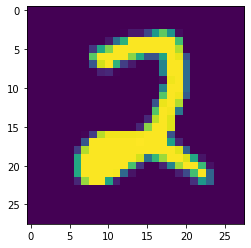

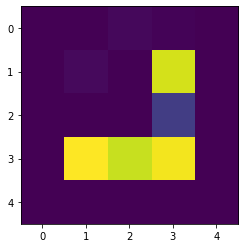

[-0.3400477  -1.2635955  -0.3148119  -0.14236152 -0.20071408 -0.66507477
 -0.16214335 -0.18351334 -0.62297136 -0.26628986] 2


In [ ]:
import matplotlib.pyplot as plt
testni = 82
plt.imshow(btest_images[testni])
plt.show()
plt.imshow(test_images[testni])
#Actually displaying the plot if you are not in interactive mode
plt.show()
print(ynew[testni], test_labels[testni])

In [ ]:
from matplotlib import test

target = [0, 0, 2, 0, 0, 0, 2, 0, 93, 0, 0, 0, 0, 17, 0, 0, 99, 91, 97, 0, 0, 0, 0, 0, 0]
for i in range(100) :
  p = []
  x = list(test_images[i].flatten())
  for j in range(25) :
    p.append(int(x[j]*100))
  if p==target: print(i)

82
